# 1. Setup

## 1.1 Install Dependencies

In [22]:
# %pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

## 1.2 Import Dependencies

In [23]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [24]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [25]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [26]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [27]:
# Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [28]:
# http://vis-www.cs.umass.edu/lfw/

In [29]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
# !tar -xf lfw.tgz

In [30]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [31]:
# Import uuid library to generate unique image names
import uuid

In [32]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\a73bb92e-7cdb-11ef-9cbf-ed8ab2114843.jpg'

In [33]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

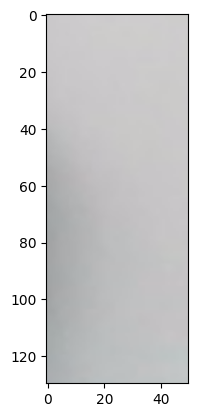

In [34]:
plt.imshow(frame[120:120+250,200:200+250, :])

# 2.x NEW - Data Augmentation

In [35]:
# def data_aug(img):
#     data = []
#     for i in range(9):
#         img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
#         img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
#         # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
#         img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
#         img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
#         img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
#         data.append(img)
    
#     return data

In [36]:
# import os
# import uuid

In [37]:
# img_path = os.path.join(ANC_PATH, '0c66a808-71d7-11ef-872e-88941a4e6a10.jpg')
# img = cv2.imread(img_path)
# augmented_images = data_aug(img)

# for image in augmented_images:
#     cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [38]:
# for file_name in os.listdir(os.path.join(POS_PATH)):
#     img_path = os.path.join(POS_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img) 
    
#     for image in augmented_images:
#         cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [39]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [40]:
dir_test = anchor.as_numpy_iterator()

In [41]:
print(dir_test.next())

b'data\\anchor\\e440f4ec-7cda-11ef-9501-ed8ab2114843.jpg'


## 3.2 Preprocessing - Scale and Resize

In [42]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [43]:
img = preprocess('data\\anchor\\e42dd587-7cda-11ef-add4-ed8ab2114843.jpg')

In [44]:
img.numpy().max() 

0.89411765

In [45]:
#dataset.map(preprocess)

## 3.3 Create Labelled Dataset

In [46]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [47]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [48]:
samples = data.as_numpy_iterator()

In [49]:
exampple = samples.next()

In [50]:
exampple

(b'data\\anchor\\8ea297ff-7cdb-11ef-9a23-ed8ab2114843.jpg',
 b'data\\positive\\8a38385b-7cdb-11ef-9d6b-ed8ab2114843.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [51]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [52]:
res = preprocess_twin(*exampple)

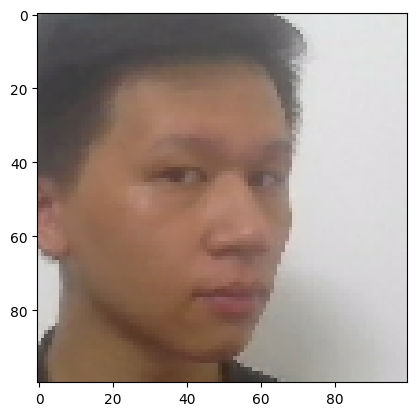

In [53]:
plt.imshow(res[1])

In [54]:
res[2]

1.0

In [55]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [56]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [57]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [58]:
inp = Input(shape=(100,100,3), name='input_image')

In [59]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [60]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [61]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [62]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [63]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [64]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [65]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [67]:
embedding = make_embedding()

In [68]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [69]:
# class L1Dist(Layer):
    
#     # Init method - inheritance
#     def __init__(self, **kwargs):
#         super(L1Dist, self).__init__(**kwargs)
       
#     # Magic happens here - similarity calculation
#     def call(self, input_embedding, validation_embedding):
#         return tf.math.abs(input_embedding - validation_embedding)
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        # Ensure the inputs are tensors
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        
        # Calculate L1 distance
        return tf.math.abs(input_embedding - validation_embedding)

In [70]:
l1 = L1Dist()

In [71]:
# l1(anchor_embedding, validation_embedding)
l1

<L1Dist name=l1_dist, built=False>

## 4.3 Make Siamese Model

In [72]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [73]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [74]:
siamese_layer = L1Dist()

In [75]:
distances = siamese_layer(inp_embedding, val_embedding)

In [76]:
classifier = Dense(1, activation='sigmoid')(distances)

In [77]:
classifier

<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [78]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [79]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [81]:
siamese_model = make_siamese_model()

In [82]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [83]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [84]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [85]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [86]:
test_batch = train_data.as_numpy_iterator()

In [87]:
batch_1 = test_batch.next()

In [88]:
X = batch_1[:2]

In [89]:
y = batch_1[2]

In [90]:
y

array([1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1.],
      dtype=float32)

In [91]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [92]:
# @tf.function
# def train_step(batch):
    
#     # Record all of our operations 
#     with tf.GradientTape() as tape:     
#         # Get anchor and positive/negative image
#         X = batch[:2]
#         # Get label
#         y = batch[2]
        
#         # Forward pass
#         yhat = siamese_model(X, training=True)
#         # Calculate loss
#         loss = binary_cross_loss(y, yhat)
#     print(loss)
        
#     # Calculate gradients
#     grad = tape.gradient(loss, siamese_model.trainable_variables)
    
#     # Calculate updated weights and apply to siamese model
#     opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
#     # Return loss
#     return loss
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X, y = batch[:2], batch[2]
        yhat = siamese_model(X, training=True)
        
        # Reshape yhat to match the shape of y
        yhat = tf.squeeze(yhat, axis=[0, 2])  # Remove dimensions of size 1
        
        loss = binary_cross_loss(y, yhat)
        
    # Compute gradients and update model parameters
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss, yhat




## 5.4 Build Training Loop

In [93]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [94]:
# def train(data, EPOCHS):
#     # Loop through epochs
#     for epoch in range(1, EPOCHS+1):
#         print('\n Epoch {}/{}'.format(epoch, EPOCHS))
#         progbar = tf.keras.utils.Progbar(len(data))
        
#         # Creating a metric object 
#         r = Recall()
#         p = Precision()
        
#         # Loop through each batch
#         for idx, batch in enumerate(data):
#             # Run train step here
#             loss = train_step(batch)
#             yhat = siamese_model.predict(batch[:2])
#             r.update_state(batch[2], yhat)
#             p.update_state(batch[2], yhat) 
#             progbar.update(idx+1)
#         print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
#         # Save checkpoints
#         if epoch % 10 == 0: 
#             checkpoint.save(file_prefix=checkpoint_prefix)

def train(data, EPOCHS):
    for epoch in range(1, EPOCHS + 1):
        print(f'\n Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        epoch_loss_avg = tf.keras.metrics.Mean()
        r = tf.keras.metrics.Recall()
        p = tf.keras.metrics.Precision()

        for idx, batch in enumerate(data):
            # Run train step here and unpack the returned values
            loss, yhat = train_step(batch)
            
            # Update the loss metric and metrics
            epoch_loss_avg.update_state(loss)
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)

            progbar.update(idx + 1)

        # Print the final results for this epoch
        print(f'Loss: {epoch_loss_avg.result().numpy()}, Recall: {r.result().numpy()}, Precision: {p.result().numpy()}')

        # Save checkpoints every 10 epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


In [95]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt

# Hàm train_step điều chỉnh lại để xử lý từng batch
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X, y = batch[:2], batch[2]
        yhat = siamese_model(X, training=True)
        
        # Reshape yhat để khớp với shape của y
        yhat = tf.squeeze(yhat)  # Loại bỏ các chiều không cần thiết
        
        # Tính loss
        loss = binary_cross_loss(y, yhat)
        
    # Tính gradient và cập nhật mô hình
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss, yhat

def train(data, EPOCHS):
    loss_history = []  # Lưu trữ lịch sử loss cho mỗi epoch
    
    for epoch in range(1, EPOCHS + 1):
        print(f'\nEpoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        epoch_loss_avg = tf.keras.metrics.Mean()
        r = tf.keras.metrics.Recall()
        p = tf.keras.metrics.Precision()

        for idx, batch in enumerate(data):
            # Thực hiện train step và lấy loss, yhat
            loss, yhat = train_step(batch)
            
            # Cập nhật loss và các metric
            epoch_loss_avg.update_state(loss)
            r.update_state(batch[2], yhat)  # batch[2] là nhãn
            p.update_state(batch[2], yhat)

            progbar.update(idx + 1)

        # Lưu giá trị loss của epoch này
        loss_history.append(epoch_loss_avg.result().numpy())
        
        # Hiển thị kết quả sau mỗi epoch
        print(f'Loss: {epoch_loss_avg.result().numpy()}, Recall: {r.result().numpy()}, Precision: {p.result().numpy()}')

        # Lưu checkpoint sau mỗi 10 epoch
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    
    # Vẽ biểu đồ loss sau khi hoàn thành huấn luyện
    plt.plot(range(1, EPOCHS + 1), loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    
    # Gọi plt.show() để hiển thị biểu đồ
    plt.show()

# Gọi hàm này để huấn luyện mô hình và vẽ biểu đồ
# train(data, EPOCHS)


## 5.5 Train the model

In [96]:
EPOCHS = 50


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
Loss: 0.6806837916374207, Recall: 0.6666666865348816, Precision: 0.7692307829856873

Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Loss: 0.5932236909866333, Recall: 0.2857142984867096, Precision: 1.0

Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Loss: 0.455865740776062, Recall: 0.20000000298023224, Precision: 1.0

Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Loss: 0.3584293723106384, Recall: 0.0714285746216774, Precision: 1.0

Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Loss: 0.40270572900772095, Recall: 0.125, Precision: 1.0

Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Loss: 0.4131089448928833, Recall: 0.23529411852359772, Precision: 1.0

Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Loss: 0.3919838070869446, Recall: 0.3529411852359772, Precision: 1.0

Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Loss: 0.3518095016479492, Recall: 0.8125, Precision: 1.0

Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Loss: 0.2965046763420105

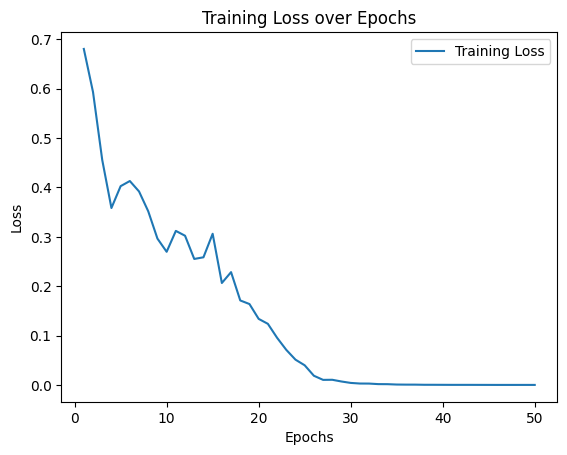

In [97]:
train(train_data, EPOCHS)

# 6. Evaluate Model

## 6.1 Import Metrics

In [98]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [99]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [100]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


array([[[9.9955356e-01],
        [1.9253346e-05],
        [6.3395230e-05],
        [1.0000000e+00],
        [1.0000000e+00],
        [9.9999779e-01],
        [4.7353340e-05],
        [1.0315946e-06],
        [9.9999976e-01],
        [9.1107009e-05],
        [9.9999982e-01],
        [1.8846325e-07],
        [9.9957716e-01]]], dtype=float32)

In [101]:
# Flatten y_hat if it's multi-dimensional (e.g., shape (batch_size, 1))
y_hat = y_hat.flatten()

# Post-process the results
y_pred = [1 if prediction > 0.5 else 0 for prediction in y_hat]


In [102]:
y_true

array([1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.], dtype=float32)

## 6.3 Calculate Metrics

In [103]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [104]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [105]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1.0 1.0


## 6.4 Viz Results

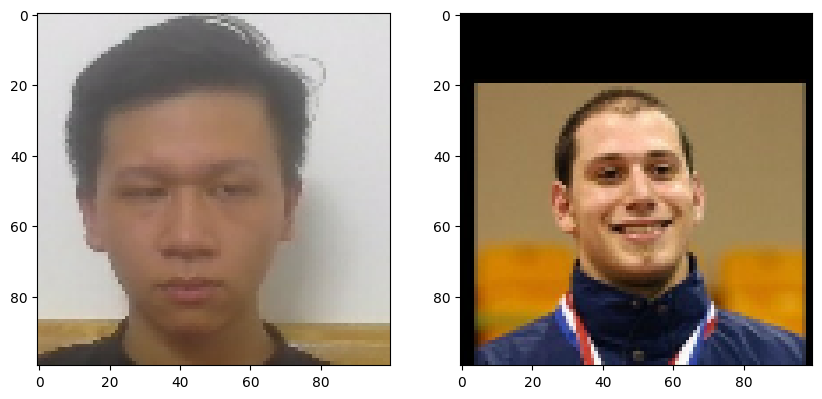

In [106]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [107]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [108]:
L1Dist

__main__.L1Dist

In [109]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [110]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


array([[[5.7933328e-05],
        [9.9999982e-01],
        [9.9999982e-01],
        [4.2103497e-07],
        [1.4029719e-06],
        [9.9957716e-01],
        [1.5701109e-04],
        [9.9980301e-01],
        [9.9999779e-01],
        [9.9999976e-01],
        [6.3395222e-05],
        [1.4291799e-05],
        [9.1107097e-05]]], dtype=float32)

In [111]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [112]:
# application_data\verification_images

In [113]:
os.listdir(os.path.join('application_data', 'verification_images'))

['036fa128-71dc-11ef-baec-88941a4e6a10.jpg',
 '045ddc67-71d7-11ef-b031-88941a4e6a10.jpg',
 '095a22fd-71d7-11ef-ac50-88941a4e6a10.jpg',
 '0f1b2bac-71d7-11ef-82a7-88941a4e6a10.jpg',
 '18b224ae-71d7-11ef-a128-88941a4e6a10.jpg']

In [114]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [115]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\036fa128-71dc-11ef-baec-88941a4e6a10.jpg
application_data\verification_images\045ddc67-71d7-11ef-b031-88941a4e6a10.jpg
application_data\verification_images\095a22fd-71d7-11ef-ac50-88941a4e6a10.jpg
application_data\verification_images\0f1b2bac-71d7-11ef-82a7-88941a4e6a10.jpg
application_data\verification_images\18b224ae-71d7-11ef-a128-88941a4e6a10.jpg


In [116]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [123]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1

In [118]:
np.sum(np.squeeze(results) > 0.9)

0

In [119]:
results

[array([[[0.0045751]]], dtype=float32),
 array([[[0.17792019]]], dtype=float32),
 array([[[0.66710246]]], dtype=float32),
 array([[[0.08433267]]], dtype=float32),
 array([[[0.09916779]]], dtype=float32)]

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz-12.1.1-win32/bin/'

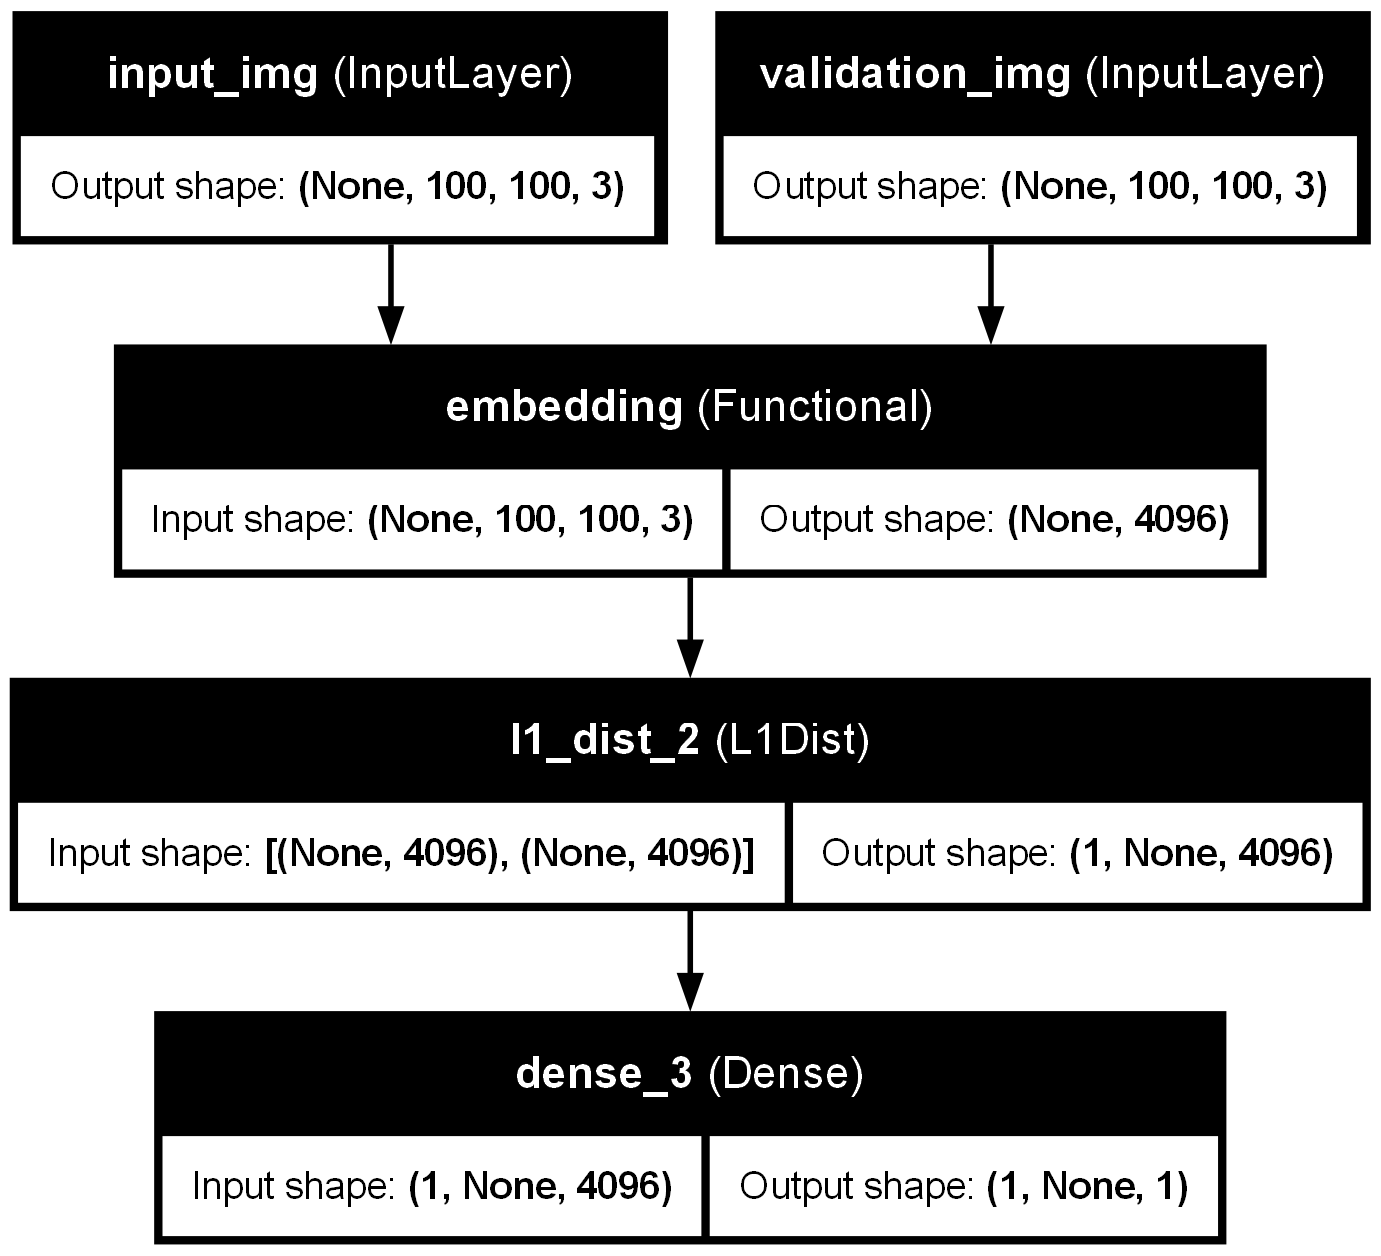

In [121]:
from keras.utils import plot_model

# Tạo biểu đồ mô hình và lưu vào tệp
plot_model(siamese_model, to_file='siamese_model_plot.png', show_shapes=True, show_layer_names=True)


In [122]:
import matplotlib.pyplot as plt

# Giả sử bạn đã huấn luyện mô hình và lưu lịch sử vào biến history
# history = model.fit(train_data, train_labels, epochs=10, validation_data=(val_data, val_labels))

# Lấy giá trị loss từ quá trình huấn luyện
loss_values = history.history['loss']  # Loss cho tập huấn luyện
val_loss_values = history.history.get('val_loss', [])  # Loss cho tập validation nếu có

# Số lượng epochs
epochs = range(1, len(loss_values) + 1)  # Tạo danh sách các epochs

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', color='b', label='Loss (Train)')
if val_loss_values:
    plt.plot(epochs, val_loss_values, marker='x', color='r', label='Loss (Validation)')  # Nếu có val_loss
plt.title('Biểu đồ Loss theo Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Đánh dấu tất cả các epochs
plt.grid()
plt.legend()
plt.show()


NameError: name 'history' is not defined